In [2]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np
import pandas as pd
#import richardsplot as rplot
from astropy.table import Table
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings('ignore')

In [3]:
! ls /Users/Trevor1/Desktop/data/files/catalogs

DR14Q_v4_4.fits
DR16Q_v4.fits
DR16Q_v4.short.csv.wrelgi
Rankine20_CIV_HeII.fits
Rankine20_CIV_HeII_wDelGI.fits
Rankine20_CIV_HeII_wDelGI_wCIVDist.csv
Rankine20_CIV_HeII_wDelGI_wCIVDist_4Latent_Jul0621.fits
dr14_4latentparams.csv
dr7_bh_May09_2011.fits


In [4]:
df = Table.read('/Users/Trevor1/Desktop/data/files/catalogs/Rankine20_CIV_HeII_wDelGI_wCIVDist_4Latent_Jul0621.fits', format='fits')
names = [name for name in df.colnames if len(df[name].shape) <= 1]
dat = df[names].to_pandas()
dat.head()

,RA_1,DEC_1,Latent1,Latent2,Latent3,Latent4,col1,SDSS_NAME,RA_2,Dec_2,...,FUV,FUV_IVAR,NUV,NUV_IVAR,FIRST_FLUX,FIRST_SNR,Delta_G_I,Separation_2,CIV_Distance,Separation
0,224.686798,49.411041,-14.322312,0.236662,-18.848540,22.101887,136894,"b""b'145844.83+492439.7'""",224.686796,49.411041,...,3.989899,1.344445,8.596096,0.566745,-1.0,-1.0,-0.168,0.000000e+00,0.667683,0.004997
1,134.407379,1.781930,-19.387080,2.453327,-20.858488,29.883472,135264,"b""b'085737.77+014654.9'""",134.407384,1.781930,...,0.000000,0.000000,0.000000,0.000000,-1.0,-1.0,-0.072,0.000000e+00,0.455856,0.017450
2,134.447922,2.642829,-11.448332,-2.163653,-18.328789,18.065598,134738,"b""b'085747.50+023834.1'""",134.447927,2.642829,...,-0.014043,623.766678,0.386053,455.497144,-1.0,-1.0,-0.102,0.000000e+00,0.400333,0.018871
3,204.398020,37.546155,-9.049964,-5.228871,-17.153719,15.109217,65563,"b""b'133735.52+373246.1'""",204.398020,37.546155,...,-0.203584,22.151609,2.255822,3.756871,-1.0,-1.0,-0.023,7.262620e-11,0.448674,0.000000
4,12.479700,14.753504,-8.696547,2.918868,-13.172476,16.237608,141283,"b""b'004955.12+144512.6'""",12.479700,14.753504,...,0.022056,106.466027,1.511081,134.563413,-1.0,-1.0,0.126,0.000000e+00,0.487539,0.000785


In [6]:
latent_params = {}
for i in range(1, 4+1): latent_params[i] = dat[["Latent%d"%i]].values.flatten()
    
#Only have latent params for ~45k quasars - mask them
latent = ~np.isnan(latent_params[1])

dat = dat[latent]

latent_params = {}
for i in range(1, 4+1): latent_params[i] = dat[["Latent%d"%i]].values.flatten()

In [11]:
z = dat[["z_paul"]].values.flatten()
blue = dat[["CIV_blue"]].values.flatten()
EW   = dat[["CIV_EW"]].values.flatten()
EW_HeII = dat[["HeII_EW"]].values.flatten()
D_GI = dat[["Delta_G_I"]].values.flatten()
good = dat[["good"]].values.flatten()
MI   = dat[["MI"]].values.flatten()
d    = 3.08e19 #cm
L2500= -0.4 * ( MI + 48.60 + 2.5*np.log10(1.+2) ) + np.log10(4*np.pi*(d**2))

fit = np.load("/Users/Trevor1/Desktop/data/files/CIV/RM_CIV_bestFitLine_noScale.npy")

civ_distances = dat[["CIV_Distance"]].values.flatten()
civ_distances.shape

(44863,)

In [12]:
def f(x, coeffs):
    y = np.zeros(len(x))
    #for i in range(len(y)):
    for k in range(len(coeffs)):
        y += coeffs[k]*(x**(-k+(len(coeffs)-1)))
    return y

In [13]:
def plot_CIV(var, varname=""):
    #Plot a given variable against CIV distance, EW, and blueshift
    global fig, ax1, ax2, ax3 #can adjust axes in other cells this way
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18,5.5))
    
    #plot variable against CIV distance
    ax1.scatter(civ_distances[good], var[good])
    ax1.set_xlabel("CIV Distance", fontsize=15)
    ax1.set_ylabel(varname, fontsize=15)
    
    #plot against CIV Blueshift
    ax2.scatter(blue[good], var[good])
    ax2.set_xlabel("Blueshift", fontsize=15)
    ax2.set_ylabel(varname, fontsize=15)
    
    #plot against CIV EW
    ax3.scatter(EW[good], var[good])
    ax3.set_xlabel("EW", fontsize=15)
    ax3.set_ylabel(varname, fontsize=15)

(29.0, 33.0)

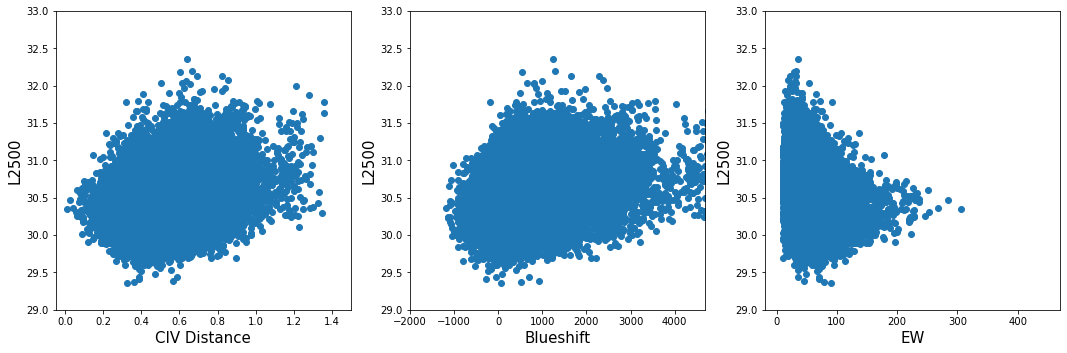

In [17]:
plot_CIV(L2500, "L2500")
ax1.set_xlim(-0.05,1.5)
ax1.set_ylim(29,33)
ax2.set_xlim(-2000,4700)
ax2.set_ylim(29,33)
ax3.set_xlim(-20,470)
ax3.set_ylim(29,33)

In [18]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.layouts import gridplot, row
from bokeh.models.markers import Circle

In [19]:
#Create the source for bokeh plots - track colors
source = ColumnDataSource(data=dict(  #create source for detections
    redshift = z[good],
    blueshift = blue[good],
    eqw = EW[good],  
    civ_dist = civ_distances[good],
    heii_ew = EW_HeII[good],
    l2500 = L2500[good],
    del_gi = D_GI[good]
))

tools = 'lasso_select,box_select,pan,box_zoom,wheel_zoom,save,reset,help'

#create a new plot with the toolbar below
p1 = figure(title=None, toolbar_location="below", tools=tools,
            x_range=[-0.7, 2.5], y_range=[28, 35])
r1 = p1.circle("del_gi", "l2500", source=source)
p1.xaxis.axis_label = 'd(g-i)'
p1.yaxis.axis_label = 'L2500'
r1.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r1.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)

p2 = figure(title=None, toolbar_location="below", tools=tools,
            x_range=[-1800, 6800], y_range=[-7,300])
r2 = p2.circle("blueshift", "eqw", source=source)
l2 = p2.line(fit[:,0], fit[:,1], color="black", line_width=4)
p2.xaxis.axis_label = 'blueshift'
p2.yaxis.axis_label = "eqw"
r2.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r2.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)

p3 = figure(title=None, toolbar_location="below", tools=tools,
            y_range=[28, 35])
r3 = p3.circle("civ_dist", "l2500", source=source)
p3.xaxis.axis_label = 'CIV Distance'
p3.yaxis.axis_label = "l2500"
r3.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r3.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)

p4 = figure(title=None, toolbar_location="below", tools=tools,
            x_range=[-2000,4700], y_range=[28, 35])
r4 = p4.circle("blueshift", "l2500", source=source)
p4.xaxis.axis_label = 'blueshift'
p4.yaxis.axis_label = "L2500"
r4.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r4.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)

p5 = figure(title=None, toolbar_location="below", tools=tools,
            x_range=[-20,470], y_range=[28, 35])
r5 = p5.circle("eqw", "l2500", source=source)
p5.xaxis.axis_label = 'eqw'
p5.yaxis.axis_label = "L2500"
r5.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r5.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)

p6 = figure(title=None, toolbar_location="below", tools=tools,
            x_range=[-1, 10], y_range=[28, 35])
r6 = p6.circle("heii_ew", "l2500", source=source)
p6.xaxis.axis_label = 'HeII EW'
p6.yaxis.axis_label = "L2500"
r6.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r6.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)

p7 = figure(title=None, toolbar_location="below", tools=tools,
            y_range=[-0.7, 2.5])
r7 = p7.circle("redshift", "del_gi", source=source)
p7.xaxis.axis_label = 'z'
p7.yaxis.axis_label = "d(g-i)"
r7.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r7.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)


# make a grid
grid = gridplot([[p1, p2, p3], [p4, p5, p6, p7]], plot_width=350, plot_height=300)

#show(row(p1,p2,p3,p4, p5))
show(grid)

---

It looks like L2500-CIV Distance can be calibrated to some level, but more cuts than are easy to with Bokeh will be necessary.  The simplest ones are cuts on redshift and $\Delta(g-i)$, but additional ones on, e.g., EW or $\Gamma$ will probably help as well.

Write some code that will basically do the exploring for me.  It should be anchored by a function that will choose random areas of a random parameter space and plot where those data points are in L2500-CIV space.

In [18]:
z = dat[["z_paul"]].values.flatten()
blue = dat[["CIV_blue"]].values.flatten()
EW   = dat[["CIV_EW"]].values.flatten()
EW_HeII = dat[["HeII_EW"]].values.flatten()
D_GI = dat[["Delta_G_I"]].values.flatten()
good = dat[["good"]].values.flatten()
MI   = dat[["MI"]].values.flatten()

In [35]:
#Create a dataframe we want to traverse through
#search_params = np.array([z, D_GI, latent_params[1], latent_params[2], latent_params[3], latent_params[4]]).T
#search_params = pd.DataFrame(search_params, columns=["z", "d(g-i)", "Latent1", "Latent2", "Latent3", "Latent4"])

search_params = np.array([latent_params[1], latent_params[2], latent_params[3], latent_params[4], D_GI]).T
search_params = pd.DataFrame(search_params, columns=["Latent1", "Latent2", "Latent3", "Latent4", "d(g-i)"])

In [36]:
search_params.columns

Index(['Latent1', 'Latent2', 'Latent3', 'Latent4', 'd(g-i)'], dtype='object')

In [37]:
from scipy.optimize import minimize
import emcee

def log_likelihood(theta, x, y, xerr, yerr):
    m, b, log_disp = theta
    model = m*x + b
    sigma2 = xerr**2 + yerr**2 + np.exp(2*log_disp)
    return -1.0 * np.sum( ((y - model)**2 / sigma2) + np.log(sigma2) )

def log_prior(theta):
    m, b, log_disp = theta
    if 0.05 < m < 3.5 and -20. < b < 40. and np.log10(0.0001) < log_disp < np.log10(12):
        return 0.0
    return -np.inf

def log_probability(theta, x, y, xerr, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, xerr, yerr)

def mcmc_fit(x, y, xerr, yerr, plot=False):
    #xerr=np.zeros(len(x))
    #yerr=np.zeros(len(y))
    
    #Check of fit for intial guess below
    fit = np.polyfit(x, y, 1)
    
    #to plot on the flux grid
    x0 = np.linspace(x.min(), x.max(), 10)
    
    #First just find ML fit for MCMC initialization
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([0.9, fit[1], np.log(10)]) + 0.1 * np.random.randn(3)
    soln = minimize(nll, initial, args=(x, y, xerr, yerr))
    m_ml, b_ml, log_disp_ml = soln.x
    
    #Initalize and run MCMC
    pos = soln.x + 1e-4 * np.random.randn(32, 3)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, xerr, yerr))
    sampler.run_mcmc(pos, 3000, progress=True)
    
    #Remove the "burn-in" period
    tau = sampler.get_autocorr_time()
    try:
        flat_samples = sampler.get_chain(discard=int(2*np.mean(tau)), thin=15, flat=True)
    except ValueError:
        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    
    #Plot the results
    if plot:
        inds = np.random.randint(len(flat_samples), size=100)
        for ind in inds:
            sample = flat_samples[ind]
            plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1, zorder=3)
        plt.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt=".b", capsize=0, alpha=0.5)
        m_true = np.percentile(flat_samples[:, 0], [50])
        b_true = np.percentile(flat_samples[:, 1], [50])
        disp_true = np.exp(np.percentile(flat_samples[:, 2], [50]))
        plt.plot(x0, m_true * x0 + b_true, "k", \
                 label="$\gamma=$%.2f, $\\beta=$%.2f, $\delta=$%.2f" % (m_true, b_true, disp_true), \
                 zorder=3)
        plt.legend(fontsize=10)
        plt.xlabel("C$_\mathrm{IV}$ Distance")
        plt.ylabel("$\log{L_{2500Å}}$")
        plt.xlim(-0.3,12)
        plt.ylim(28,35)
        #plt.gca().set_aspect("equal")
        plt.show()
    
    #Return gamma+uncertainties, dispersion
    return np.percentile(flat_samples[:, 0], [16, 50, 84]), np.exp(np.percentile(flat_samples[:, 2], [50]))

def find(x, y, search_params, niter=1, chunk=10, dp=1, cuts=None, check=False):
    
    #Return a region of space according to some recursive random cuts
    if niter == 0:
        dust_reddened = (search_params.iloc[:,search_params.columns=="d(g-i)"]>0.3).values.flatten()
        return cuts, search_params[~dust_reddened].index
    
    #Do MCMC fit to get initial dispersion
    if check:
        gamma_curr, disp_curr = mcmc_fit(x, y, np.zeros(len(x)), np.zeros(len(y)))
    
    #Eliminate dust-reddened objects
    dust_reddened = (search_params.iloc[:,search_params.columns=="d(g-i)"]>0.3).values.flatten()
    search_params = search_params[~dust_reddened]
    x = x[~dust_reddened]
    y = y[~dust_reddened]
    
    #ind_prop = np.random.randint(search_params.shape[1]) #randomly choose a property to constrain
    ind_prop = np.random.randint(search_params.shape[1]-1) #minus 1 to not cut d(g-i)
    name = search_params.columns[ind_prop]
    prop = search_params.iloc[:,ind_prop].values
    #print("Randomly chose to constrain %s" % name)
    
    #We'll randomly choose a range of values for the randomly chosen parameter
    percentiles = np.arange(0, 100+dp, dp)
    #ind_percent = np.random.randint(chunk//dp, len(percentiles)-(chunk//dp))
    ind_percent = np.random.randint(100-chunk//dp)
    l_per, r_per = percentiles[ind_percent], percentiles[ind_percent+chunk//dp]
    l_prop, r_prop = np.percentile(prop, [l_per, r_per])
    
    #Create the mask to cut the data frame
    mask = (prop>=l_prop) & (prop<=r_prop)
    
    if check:
        #Do another MCMC fit with new mask- if dispersion hasn't decreased, reject (how to do that?)
        gamma_new, disp_new = mcmc_fit(x[mask], y[mask], 
                                       np.zeros(len(x[mask])), np.zeros(len(y[mask])))
        if disp_new >= disp_curr:
            print("Rejected cut: %.2f < %s < %.2f" % (l_prop, name, r_prop))
            cuts, cut_indices = find(x, y, search_params, niter, chunk=chunk, dp=dp, cuts=cuts)
        #Cut the data niter times
        else:
            print("Accepted cut: Randomly chose to constrain %s" % name)
            print("Will draw between the %d and %dth percentile: %.2f < %s < %.2f" % (l_per, r_per, l_prop, name, r_prop))
            #cuts += ("%.2f < %s < %.2f,"  % (l_prop, name, r_prop))
            cuts, cut_indices = find(x[mask], y[mask], search_params[mask], niter-1, chunk=chunk, dp=dp, cuts=cuts)
    else:
        #print("Will draw between the %d and %dth percentile: %.2f < %s < %.2f" % (l_per, r_per, l_prop, name, r_prop))
        #cuts += ("%.2f < %s < %.2f,"  % (l_prop, name, r_prop))
        cuts, cut_indices = find(x[mask], y[mask], search_params[mask], niter-1, chunk=chunk, dp=dp, cuts=cuts)

        
    
    #cut_indices = find(search_params[mask], niter-1)
    #Return cut-down dataframe and the indices w.r.t. original dataframe
    return search_params.loc[cut_indices], cut_indices

#def plot_subsample(ax):

6/28/2021: Ignore the ``if check`` condition -- that is meant to check the dispersion after each cut to see if a cut was effective or not.

In [38]:
def plot_quasar_space(mask):
    fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(20, 11))
    ax1.scatter(z, D_GI, alpha=0.5)
    ax1.scatter(z[mask], D_GI[mask])
    ax1.set_ylim(-0.7, 2.5)
    ax1.set_xlabel("z")
    ax1.set_ylabel("d(g-i)")
    
    ax2.scatter(blue, EW, alpha=0.5)
    ax2.scatter(blue[mask], EW[mask], color="red")
    ax2.set_xlim(-1800, 6800)
    ax2.set_ylim(-7, 300)
    ax2.set_xlabel("CIV Blueshift")
    ax2.set_ylabel("CIV EW")
    
    ax3.scatter(civ_distances, L2500, alpha=0.5)
    ax3.scatter(civ_distances[mask], L2500[mask], color="red")
    ax3.set_xlim(-0.05,1.5)
    ax3.set_ylim(29,33)
    ax3.set_xlabel("CIV Distance")
    ax3.set_ylabel("L2500")
    
    ax4.scatter(blue, L2500, alpha=0.5)
    ax4.scatter(blue[mask], L2500[mask], color="red")
    ax4.set_xlim(-2000, 4700)
    ax4.set_ylim(29,33)
    ax4.set_xlabel("CIV Blueshift")
    ax4.set_ylabel("L2500")
    
    ax5.scatter(EW, L2500, alpha=0.5)
    ax5.scatter(EW[mask], L2500[mask], color="red")
    ax5.set_xlim(-20, 470)
    ax5.set_ylim(29,33)
    ax5.set_xlabel("CIV EW")
    ax5.set_ylabel("L2500")
    
    ax6.scatter(EW_HeII, L2500, alpha=0.5)
    ax6.scatter(EW_HeII[mask], L2500[mask], color="red")
    ax6.set_xlim(-1,10)
    ax6.set_ylim(29,33)
    ax6.set_xlabel("HeII EW")
    ax6.set_ylabel("L2500")
    
    plt.show()

def cut_legend(df):
    cuts = [str(round(df.iloc[:,i].min(),3))+"<"+df.columns[i]+"<"+str(round(df.iloc[:,i].max(),3)) for i in range(df.shape[1])]
    return cuts 

cut_legend(search_params)

['-701.628<Latent1<15.465',
 '-101.169<Latent2<341.868',
 '-79.019<Latent3<52.705',
 '3.288<Latent4<1724.088',
 '-9.0<d(g-i)<5.829']

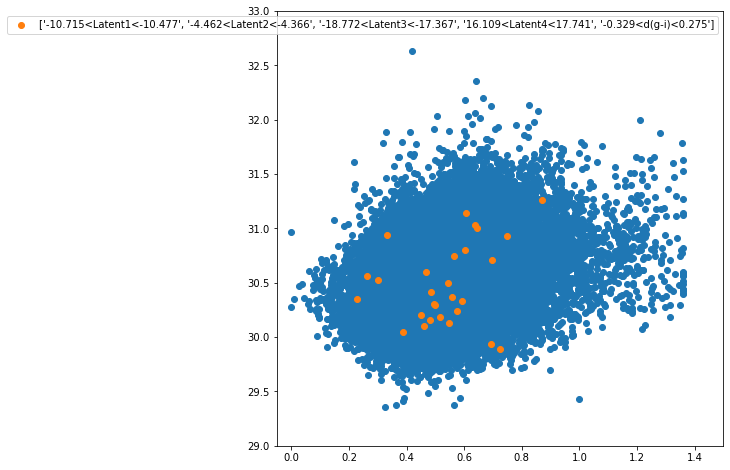

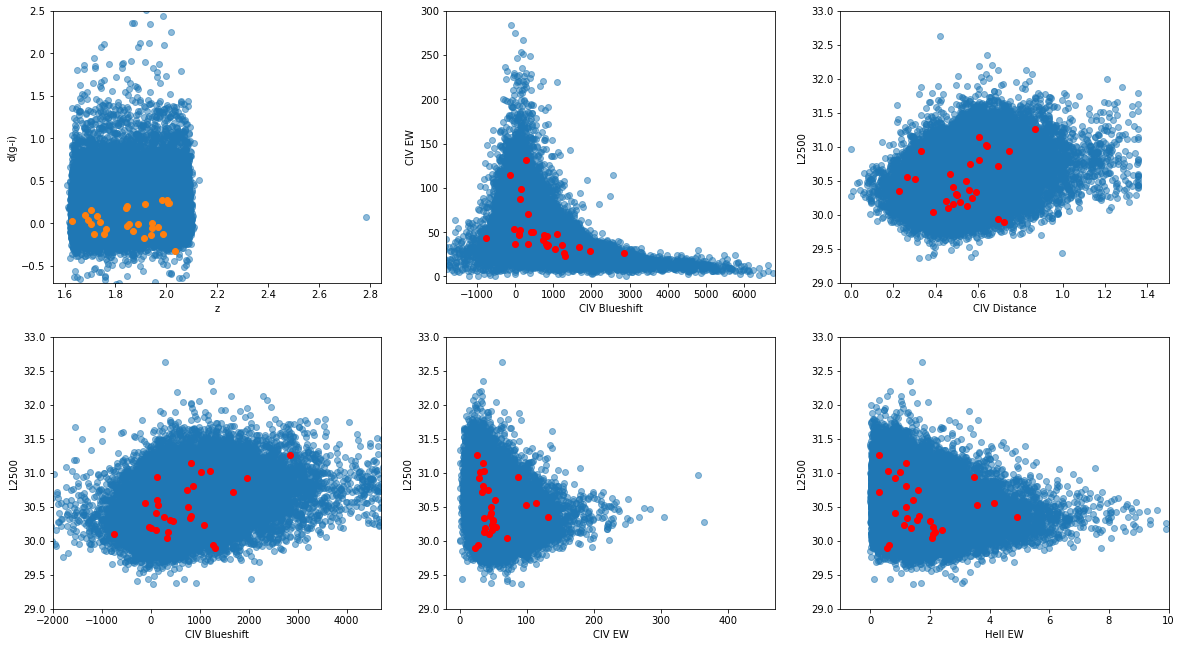

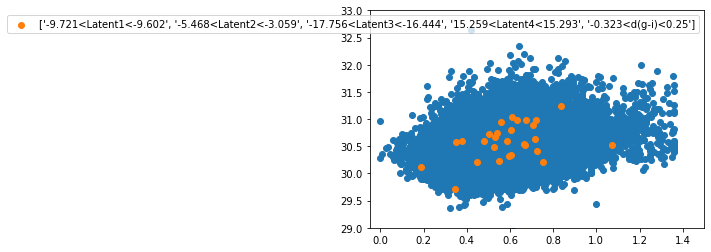

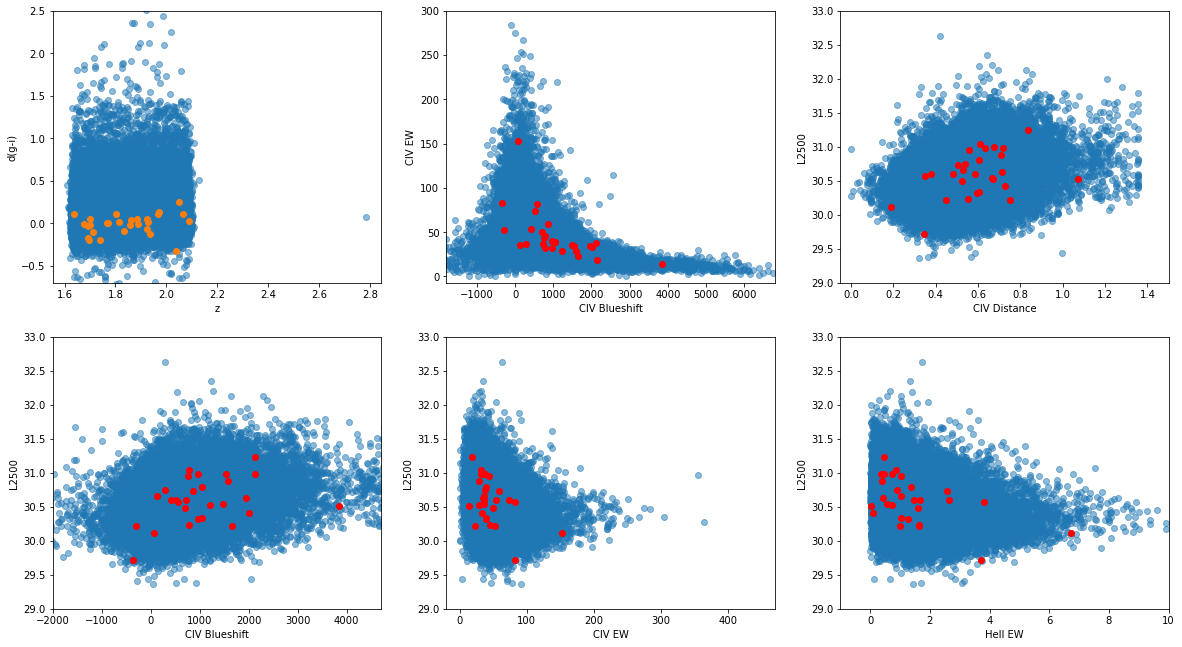

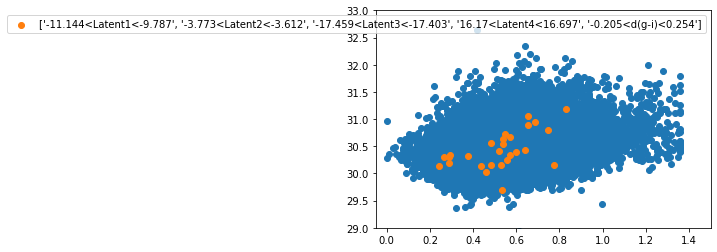

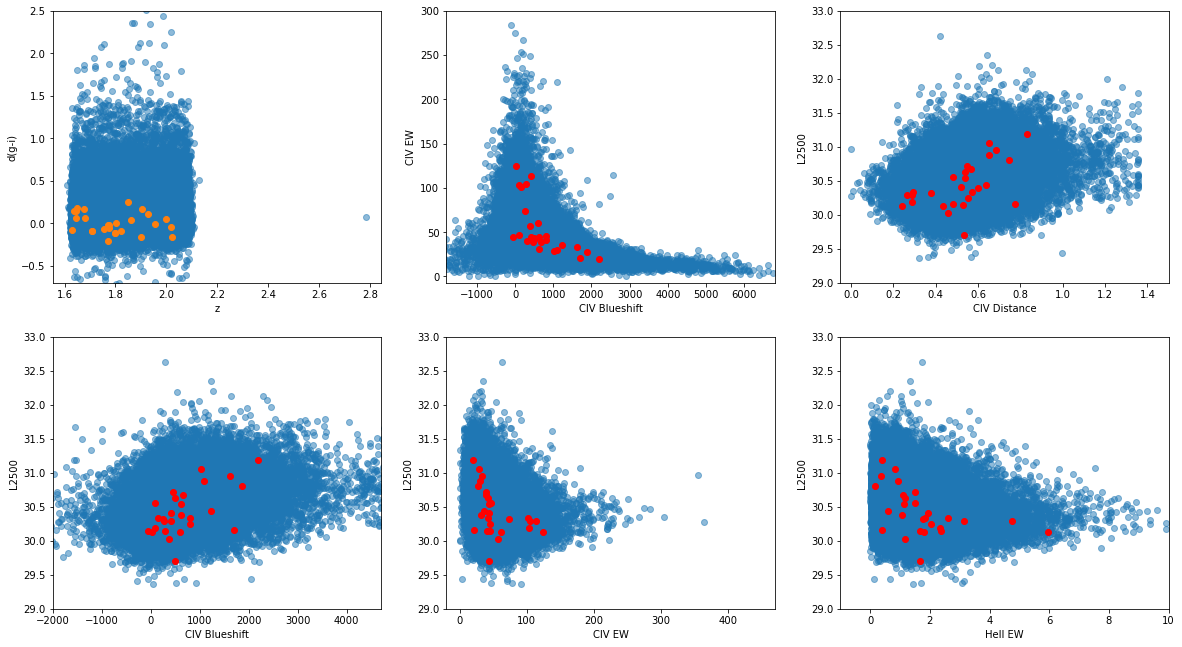

In [39]:
N = 3
subsamples = []
sub_inds = []

for i in range(N):
    cuts, cuts_indices = find(civ_distances, L2500, search_params, chunk=30, niter=6)
    subsamples.append(cuts)
    sub_inds.append(cuts_indices)
    
    
fig = plt.figure(figsize=(8,8))
for i in range(len(subsamples)):
    if i > 0:
        plt.cla()
    plt.xlim(-0.05,1.5)
    plt.ylim(29,33)
    plt.scatter(civ_distances, L2500)
    plt.scatter(civ_distances[sub_inds[i]], L2500[sub_inds[i]], label=cut_legend(subsamples[i]))
    plt.legend(loc="best")
    plot_quasar_space(sub_inds[i])
    #plt.pause(1.0)

#plt.show()

In [40]:
civ_distances.shape

(44863,)

In [27]:
dat["CIV_Dist"] = civ_distances
dat.head()

,SDSS_NAME,RA,Dec,z_paul,good,nBAL,AIi,BIi,CIV_blue,CIV_EW,...,LUM_0.2_12.0keV,FUV,FUV_IVAR,NUV,NUV_IVAR,FIRST_FLUX,FIRST_SNR,Delta_G_I,Separation,CIV_Dist
0,b'003708.46+002855.8',9.285266,0.482174,3.02295,True,False,False,True,691.966469,75.072475,...,NaN,0.032006,45.552314,-0.018692,3.531072,-1.0,-1.0,0.600,0.000000e+00,4.577663
1,b'004959.24+001903.1',12.496858,0.317540,3.32150,True,False,False,True,857.180965,32.148782,...,NaN,-0.079175,12.024832,-0.040529,3.323599,-1.0,-1.0,0.375,1.144982e-11,5.020065
2,b'015017.70+002902.4',27.573786,0.484025,3.00333,True,False,False,True,1474.865400,31.916310,...,NaN,-0.068240,1074.827534,0.183702,373.859257,-1.0,-1.0,0.167,2.289918e-11,5.759200
3,b'023238.49-001936.2',38.160390,-0.326749,3.34348,True,False,False,True,715.316626,40.857802,...,NaN,-0.042674,229.386872,0.313899,1.875008,-1.0,-1.0,0.831,0.000000e+00,4.805984
4,b'072047.82+405455.5',110.199280,40.915418,3.04179,True,False,False,True,195.093283,106.332340,...,NaN,-0.394990,7.126986,0.070899,32.722264,-1.0,-1.0,-0.159,0.000000e+00,3.241741


In [28]:
!ls

CIV_plots_explore.ipynb
CIV_plots_explore_amyData.ipynb
CIV_plots_explore_amyData_movie.ipynb
CIVfunctions.py
HST_spectra_noBAL.ipynb
HST_spectra_sdssfits.ipynb
ICAfitting_prelim.ipynb
ICAfitting_wmasks.ipynb
Montecarlo_prelim.ipynb
README.md
__pycache__
autoencoder.ipynb
autoencoder2.ipynb
autoencoder3.ipynb
dr16qsocat_czrSF11.061821.dat
getting_started.ipynb
grdr7.8403col.radec.platemjdfiber.csv
grdr7.8403col.radec.platemjdfiber_w4LatentParams.csv
kimball_catalog_full.ipynb
kimball_catalog_small.ipynb
random_corrs.py
speclist_8403_VLA_colselected.txt


dat.to_csv("/Users/Trevor1/Desktop/data/files/catalogs/Rankine20_CIV_HeII_wDelGI_wCIVDist.csv")

In [41]:
!ls /Users/Trevor1/Desktop/data/files/CIV

CIVfunctions.py                bestfit_linear.npy
RM_CIV_bestFitLine_noScale.npy


np.save("/Users/Trevor1/Desktop/data/files/CIV/bestfit_linear.npy", fit)

Another step in this should be to save subsamples with similar slopes.  Then we can plot all of them to see if there's some sort of simple correction to make so that they all align.

Just save slope and plot as a function of redshift and d(g-i).

In [58]:
N = 3000 #how many samples to take

#Save the names of cuts and the masks
subsamples = [] #CHANGE: return the actual subsample, not a string of the cuts made.
sub_inds = []

#Want to save the centers of bins for each cut, since we'll plot slope+intercept
#z_list = []
#dgi_list = []

L1 = []
L2 = []
L3 = []
L4 = []

slope_list = []
int_list = []

for i in range(N):
    cuts, cuts_indices = find(civ_distances, L2500, search_params, chunk=10, niter=3)
    subsamples.append(cuts)
    sub_inds.append(cuts_indices)
    #z_list.append(subsamples[i]["z"].median())
    #dgi_list.append(subsamples[i]["d(g-i)"].median())
    L1.append(subsamples[i]["Latent1"].median())
    L2.append(subsamples[i]["Latent2"].median())
    L3.append(subsamples[i]["Latent3"].median())
    L4.append(subsamples[i]["Latent4"].median())
    
    #See what the slope and intercept of a linear fit are in this bin
    linear_fit = np.polyfit(civ_distances[sub_inds[i]], L2500[sub_inds[i]], 1)
    slope_list.append(linear_fit[0])
    int_list.append(linear_fit[1])

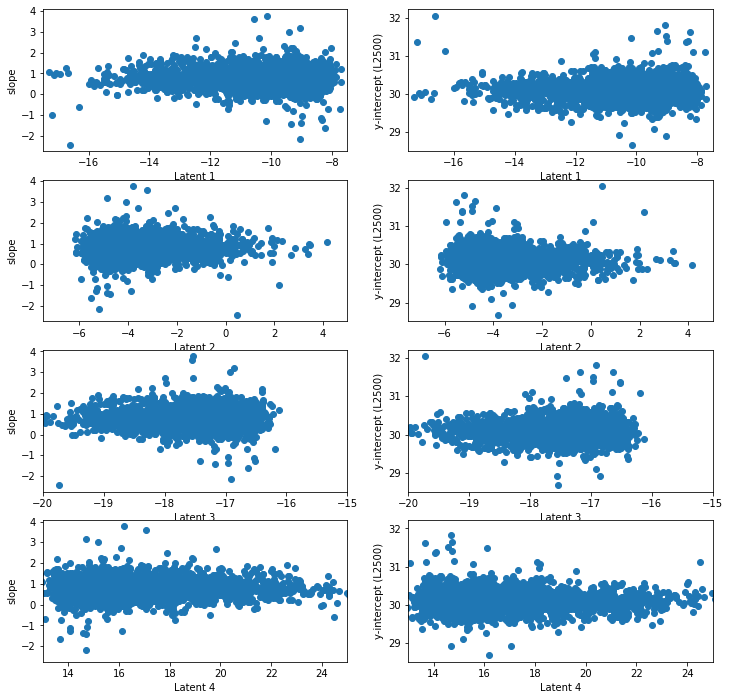

In [59]:
fig, axs = plt.subplots(4, 2, figsize=(12,12))

def plot_linfit(axs, prop_list, prop_name, xlims):
    axs[0].scatter(prop_list, slope_list)
    axs[0].set_xlim(xlims)
    #axs[0].set_ylim(ylims)
    axs[0].set_xlabel(prop_name)
    axs[0].set_ylabel("slope")

    axs[1].scatter(prop_list, int_list)
    axs[1].set_xlim(xlims)
    #axs[1].set_ylim(ylims)
    axs[1].set_xlabel(prop_name)
    axs[1].set_ylabel("y-intercept (L2500)")
"""    
plot_latent(CIVdist[latent], latent_params[1][latent], [-0.1,1.5], [-25,-5], 1)
plot_latent(CIVdist[latent], latent_params[2][latent], [-0.1,1.5], [-7.5,5], 2)
plot_latent(CIVdist[latent], latent_params[3][latent], [-0.1,1.5], [-25,-5], 3)
plot_latent(CIVdist[latent], latent_params[4][latent], [-0.1,1.5], [8,25], 4) 
"""

plot_linfit(axs[0], L1, "Latent 1", [-17.5,-7.5])
plot_linfit(axs[1], L2, "Latent 2", [-7.5,5])
plot_linfit(axs[2], L3, "Latent 3", [-20,-15])
plot_linfit(axs[3], L4, "Latent 4", [13,25])

So it looks like there is:

- y-intercept correlates with redshift, as expected (also $∆(g-i)$ but clearly redshift more)
- There's a strange, but seemingly well-defined, trend between the slope of the relation and $∆(g-i)$.

So if we read in an object's CIV distance, redshift, and $∆(g-i)$, we will apply some correction to the object's L2500Å and then see what the data look like.

In [62]:
def print_fit(xvar, yvar, coeffs):
    my_str = ""
    for i in range(len(coeffs)-1):
        my_str += "%.2fx^%d + " % (coeffs[i], (-i+(len(coeffs)-1)))
        
    print(my_str + str(round(coeffs[-1], 2)))
    
#Find mode of given distribution  
def find_mode(z, D_GI):
    z = np.array(z)
    D_GI = np.array(D_GI)
    
    nbins = 20
    zleft, zright = np.percentile(z, [1, 99])
    dz = (zright-zleft) / nbins
    zbins = np.arange(zleft+(dz/2), zright, dz)
    
    modal_colors = np.zeros(len(zbins))
    for i in range(len(zbins)):
        modal_colors[i] = np.median(D_GI[((z>=(zbins[i]-dz/2))&(z<(zbins[i]+dz/2)))])
        #modal_colors[i] = 3*np.median(D_GI[((z>=(zbins[i]-dz/2))&(z<(zbins[i]+dz/2)))]) - 2*np.mean(D_GI[((z>=(zbins[i]-dz/2))&(z<(zbins[i]+dz/2)))])
    return zbins, modal_colors

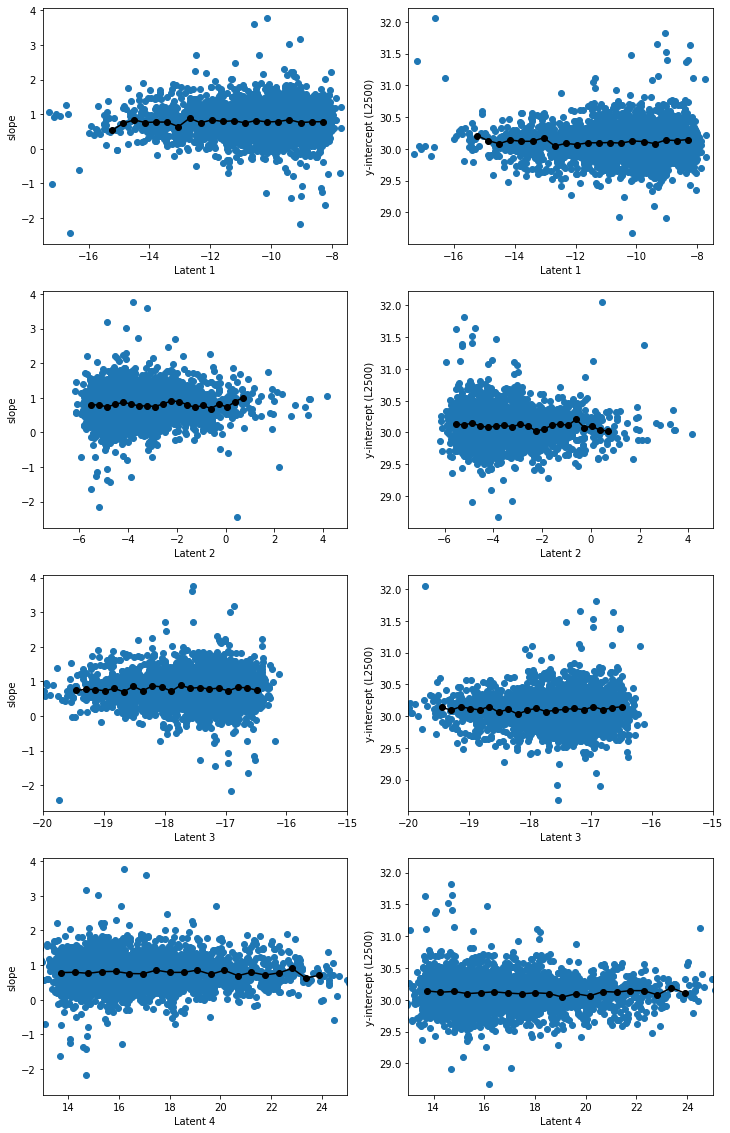

In [63]:
def plot_linfit_mode(axs, prop_list, prop_name, xlims):
    prop_bins, slope_meds = find_mode(prop_list, slope_list)
    axs[0].scatter(prop_list, slope_list)
    axs[0].plot(prop_bins, slope_meds, "-o", color="k")
    axs[0].set_xlim(xlims)
    #axs[0].set_ylim(ylims)
    axs[0].set_xlabel(prop_name)
    axs[0].set_ylabel("slope")
    
    prop_bins, int_meds = find_mode(prop_list, int_list)
    axs[1].scatter(prop_list, int_list)
    axs[1].plot(prop_bins, int_meds, "-o", color="k")
    axs[1].set_xlim(xlims)
    #axs[1].set_ylim(ylims)
    axs[1].set_xlabel(prop_name)
    axs[1].set_ylabel("y-intercept (L2500)")

fig, axs = plt.subplots(4, 2, figsize=(12,20))
    
plot_linfit_mode(axs[0], L1, "Latent 1", [-17.5,-7.5])
plot_linfit_mode(axs[1], L2, "Latent 2", [-7.5,5])
plot_linfit_mode(axs[2], L3, "Latent 3", [-20,-15])
plot_linfit_mode(axs[3], L4, "Latent 4", [13,25])

So it doesn't look like the latent parameters really track the slope or y-intercept of the L2500-CIVDist relationship.

In [35]:
f'{x_dgi=}'.split('=')[0]

'x_dgi'

Note: A simple fit to these isn't easy, so I tracked the median instead -- which might actually be a better way to do it anyway.

In [36]:
len(dgi_bins)

20

The algorithm now is simply:

1) Feed an array of the object's CIV distance, redshift, and $∆(g-i)$

2) For the median quasar with this $∆(g-i)$ and redshift, the slope and y-intercept of the L2500-CIV distance relationship is ``slope, y_int = slope_meds[(D_GI-dgi_bins).argmin()], int_meds[(Z-z_bins).argmin()]``

3) Compute the "corrected" luminosity as ``L_corr = CIV_dist*slope + y_int``

Think this should work?  If not, could always edit cuts in ``find()`` function above.

In [37]:
data = pd.DataFrame(np.array([civ_distances, z, D_GI, L2500]).T, columns=["CIVdist", "z", "d(g-i)", "L2500"])
data.head()

,CIVdist,z,d(g-i),L2500
0,4.577663,3.02295,0.600,31.140400
1,5.020065,3.32150,0.375,30.557201
2,5.759200,3.00333,0.167,31.358955
3,4.805984,3.34348,0.831,31.039951
4,3.241741,3.04179,-0.159,30.541111


In [38]:
MEDSLOPE = np.median(slope_list)
MEDINT = np.median(int_list)

def corrector(df):
    #Load in individual arrays
    CIVdist = df[["CIVdist"]].values.flatten()
    z = df[["z"]].values.flatten()
    DGI = df[["d(g-i)"]].values.flatten()
    L2500 = df[["L2500"]].values.flatten()
    L2500_corr = np.zeros(len(df))
    
    for i in range(len(df)):
        DGI_slope_old = slope_meds[abs(DGI[i]-dgi_bins).argmin()] #d(g-i) controls the slope
        z_int_old = int_meds[abs(z[i]-z_bins).argmin()]       #z controls the y-intercept
        Lpred_old = DGI_slope_old*CIVdist[i] + z_int_old
        
        #If this quasar were the median quasar- given CIV distance, what would "fitted" luminosity be?
        Lpred_med = MEDSLOPE*CIVdist[i] + MEDINT
        
        #Now take *actual measured* luminosity and add the difference to it
        dL = Lpred_med - Lpred_old
        L2500_corr[i] = L2500[i] + dL
        
    df["L2500_corr"] = L2500_corr
    return df

In [39]:
data_fixed = corrector(data)
data_fixed.head()

,CIVdist,z,d(g-i),L2500,L2500_corr
0,4.577663,3.02295,0.600,31.140400,30.903320
1,5.020065,3.32150,0.375,30.557201,30.332095
2,5.759200,3.00333,0.167,31.358955,31.222223
3,4.805984,3.34348,0.831,31.039951,30.807655
4,3.241741,3.04179,-0.159,30.541111,30.399755


In [40]:
L2500_old = data_fixed[["L2500"]].values.flatten()
L2500_new = data_fixed[["L2500_corr"]].values.flatten()

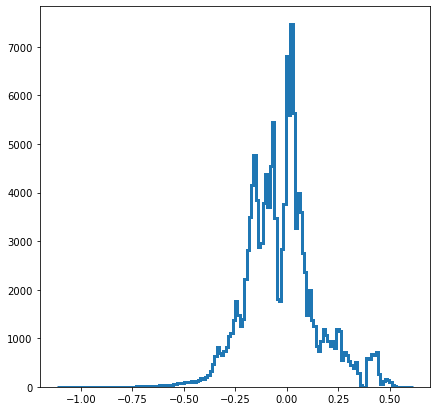

In [41]:
fig = plt.figure(figsize=(7,7))
plt.hist(L2500_old-L2500_new, histtype="step", linewidth=3, bins="scott")
plt.show()

Think that's good?

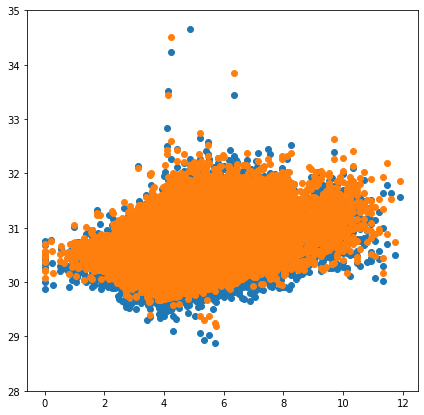

In [42]:
fig = plt.figure(figsize=(7,7))
plt.scatter(civ_distances[good], L2500_old[good])
plt.scatter(civ_distances[good], L2500_new[good])
plt.ylim(28,35)
plt.show()

Not as effective as I was hoping for.  Could maybe try making this iterative and see how far we can get (without completely mangling the original data).

Play around with Bokeh to see if it helped any more than what it looks like.

In [43]:
#Create the source for bokeh plots - track colors
source = ColumnDataSource(data=dict(  #create source for detections
    redshift = z[good],
    blueshift = blue[good],
    eqw = EW[good],  
    civ_dist = civ_distances[good],
    heii_ew = EW_HeII[good],
    L2500_new = L2500_new[good],
    del_gi = D_GI[good]
))

tools = 'lasso_select,box_select,pan,box_zoom,wheel_zoom,save,reset,help'

#create a new plot with the toolbar below
p1 = figure(title=None, toolbar_location="below", tools=tools,
            x_range=[-0.7, 2.5], y_range=[28, 35])
r1 = p1.circle("del_gi", "L2500_new", source=source)
p1.xaxis.axis_label = 'd(g-i)'
p1.yaxis.axis_label = 'L2500_new'
r1.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r1.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)

p2 = figure(title=None, toolbar_location="below", tools=tools,
            x_range=[-1800, 6800], y_range=[-7,300])
r2 = p2.circle("blueshift", "eqw", source=source)
l2 = p2.line(fit[:,0], fit[:,1], color="black", line_width=4)
p2.xaxis.axis_label = 'blueshift'
p2.yaxis.axis_label = "eqw"
r2.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r2.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)

p3 = figure(title=None, toolbar_location="below", tools=tools,
            y_range=[28, 35])
r3 = p3.circle("civ_dist", "L2500_new", source=source)
p3.xaxis.axis_label = 'CIV Distance'
p3.yaxis.axis_label = "L2500_new"
r3.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r3.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)

p4 = figure(title=None, toolbar_location="below", tools=tools,
            x_range=[-2000,4700], y_range=[28, 35])
r4 = p4.circle("blueshift", "L2500_new", source=source)
p4.xaxis.axis_label = 'blueshift'
p4.yaxis.axis_label = "L2500_new"
r4.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r4.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)

p5 = figure(title=None, toolbar_location="below", tools=tools,
            x_range=[-20,470], y_range=[28, 35])
r5 = p5.circle("eqw", "L2500_new", source=source)
p5.xaxis.axis_label = 'eqw'
p5.yaxis.axis_label = "L2500_new"
r5.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r5.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)

p6 = figure(title=None, toolbar_location="below", tools=tools,
            x_range=[-1, 10], y_range=[28, 35])
r6 = p6.circle("heii_ew", "L2500_new", source=source)
p6.xaxis.axis_label = 'HeII EW'
p6.yaxis.axis_label = "L2500_new"
r6.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r6.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)

p7 = figure(title=None, toolbar_location="below", tools=tools,
            y_range=[-0.7, 2.5])
r7 = p7.circle("redshift", "del_gi", source=source)
p7.xaxis.axis_label = 'z'
p7.yaxis.axis_label = "d(g-i)"
r7.selection_glyph = Circle(fill_color='firebrick', line_color=None)
r7.nonselection_glyph = Circle(fill_color='#1f77b4', fill_alpha=0.1, line_color=None)


# make a grid
grid = gridplot([[p1, p2, p3], [p4, p5, p6, p7]], plot_width=350, plot_height=300)

#show(row(p1,p2,p3,p4, p5))
show(grid)

----

Draw some constant-CIV-distance lines.